## Objectives

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit.

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted.

<b> The objective of this project is to build a model that borrowers can use to help make the best financial decisions, by predicting the probability that somebody will experience financial distress in the next two years. </b>

---------------------------------------------------------------------------------------------------------------

<b><u> Data Dictionary </u></b>

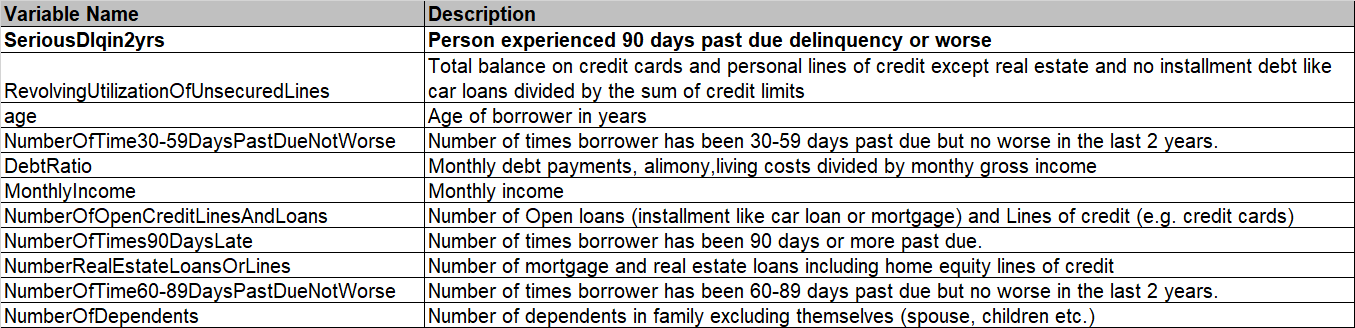

## Importing Modules

In [1]:
# importing the basic modules

import pandas as pd
import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
# importing ML modules

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, r2_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

D:\GA\Anaconda\envs\py3.6\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading Dataset

In [3]:
train = './cs-training.csv'

In [4]:
train_df = pd.read_csv(train)

## EDA

<b> Data Dictionary </b>

In [5]:
train_df.shape

(150000, 12)

In [6]:
train_df.sample(5)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
6093,6094,0,0.332828,39,1,0.138465,4000.0,7,0,0,0,1.0
63471,63472,0,0.201491,68,0,0.236566,6475.0,5,0,1,0,0.0
48197,48198,0,0.049090,51,0,0.225590,19100.0,11,0,2,0,3.0
130263,130264,0,0.468154,50,0,0.438509,3406.0,8,0,1,0,2.0
11506,11507,1,1.122503,34,2,1.800499,400.0,3,1,0,2,1.0


In [7]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
train_df.isnull().sum().sort_values(ascending=False)

MonthlyIncome                           29731
NumberOfDependents                       3924
NumberOfTime60-89DaysPastDueNotWorse        0
NumberRealEstateLoansOrLines                0
NumberOfTimes90DaysLate                     0
NumberOfOpenCreditLinesAndLoans             0
DebtRatio                                   0
NumberOfTime30-59DaysPastDueNotWorse        0
age                                         0
RevolvingUtilizationOfUnsecuredLines        0
SeriousDlqin2yrs                            0
dtype: int64

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


### Start of EDA

D:\GA\Anaconda\envs\py3.6\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\GA\Anaconda\envs\py3.6\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
D:\GA\Anaconda\envs\py3.6\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\GA\Anaconda\envs\py3.6\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


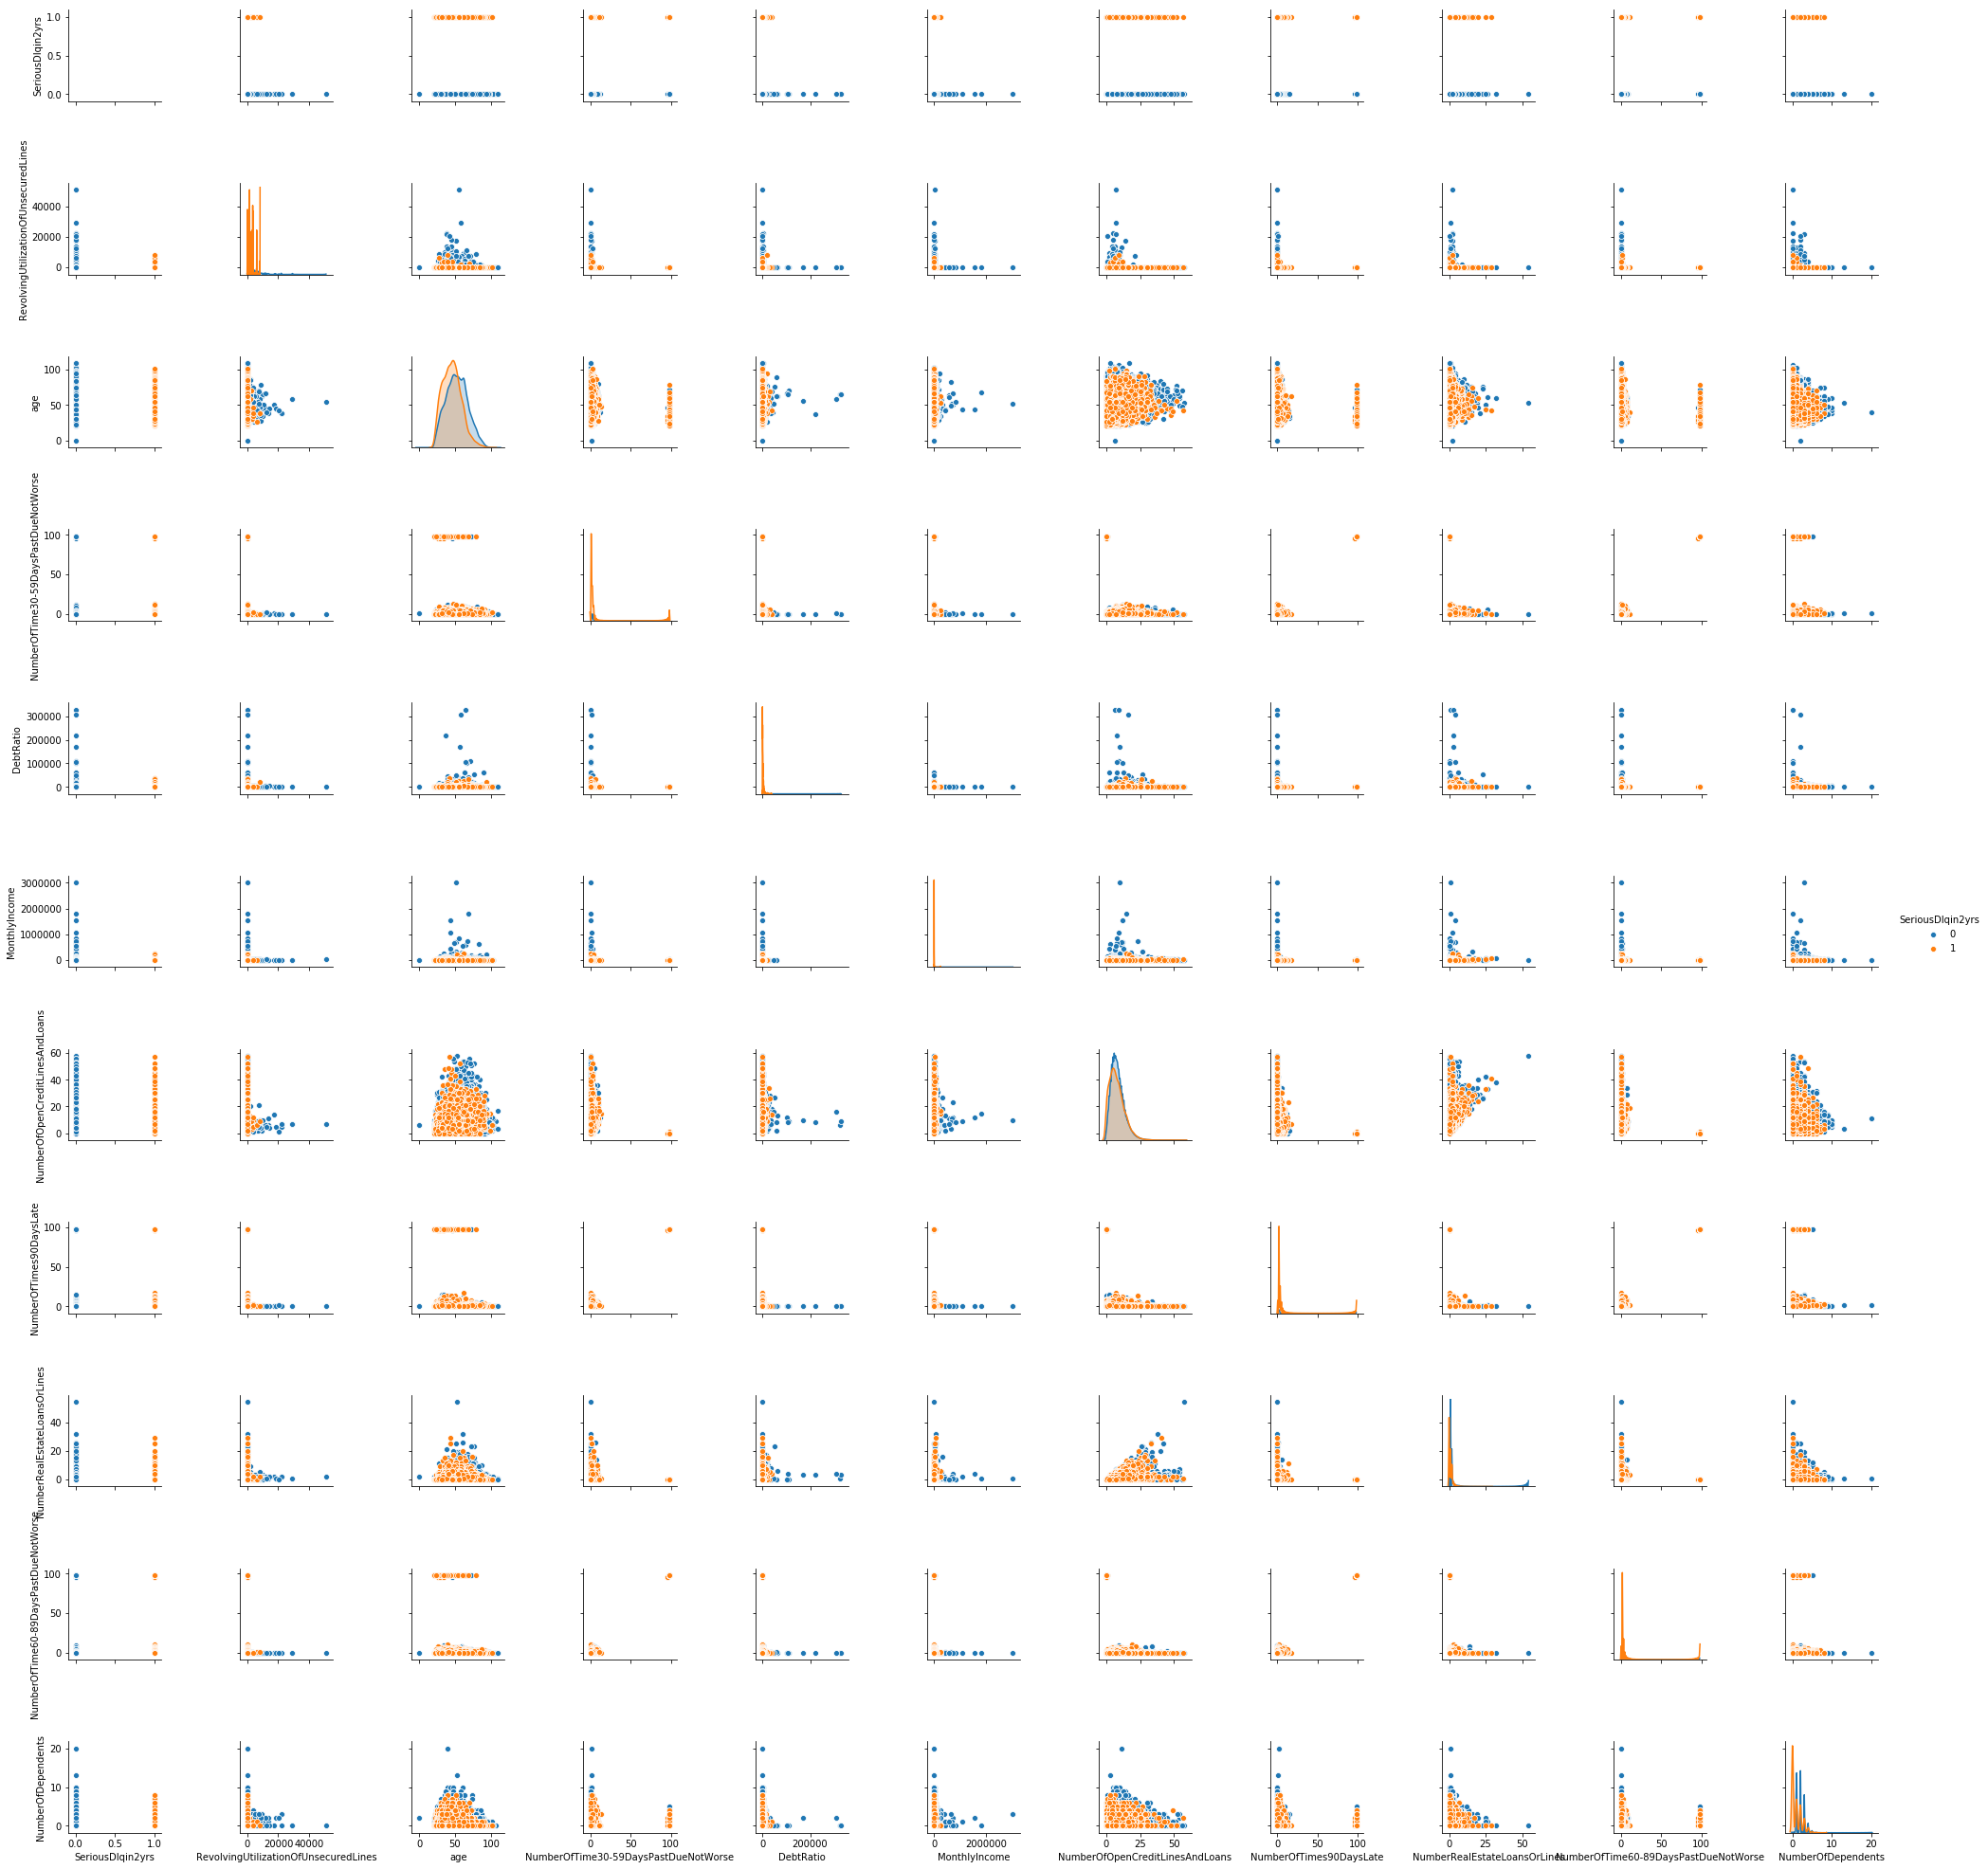

In [10]:
sns.pairplot(train_df, hue='SeriousDlqin2yrs')

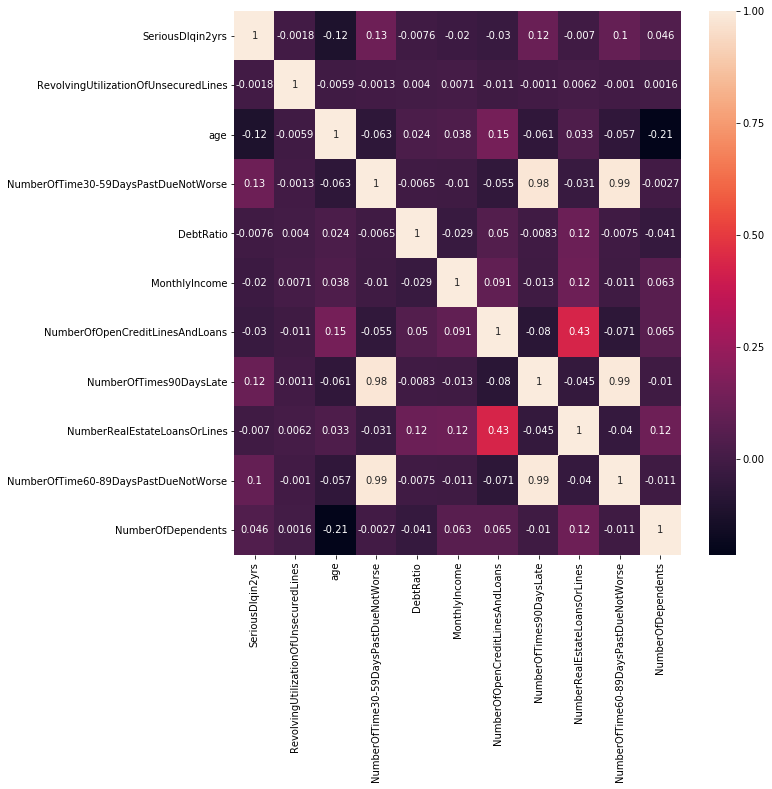

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(), annot=True)

In [12]:
# filling up null values

# filling up Number of Dependents with 0

train_df['NumberOfDependents'].fillna(0, inplace=True)

We will fill up the NA values for Monthly Income based on the age band median monthly income.

In [13]:
# filling up Monthly Income null values

# we will be categorizing the age columns based on age band of 10 years, ie. 1-10, 11-20, etc.

train_df['age_band'] = train_df['age'].apply(lambda x: '1 to 10' if 1<=x<10 else
                                            ('11 to 20' if 11<=x<=20 else
                                            ('21 to 30' if 21<=x<=30 else
                                            ('31 to 40' if 31<=x<=40 else
                                            ('41 to 50' if 41<=x<=50 else
                                            ('51 to 60' if 51<=x<=60 else
                                            ('61 to 70' if 61<=x<=70 else
                                            ('71 to 80' if 71<=x<=80 else
                                            ('81 to 90' if 81<=x<=90 else
                                            ('91 to 100' if 91<=x<=100 else
                                            ('100 to 110' if 100<=x<=110 else x
                                            )))))))))))

In [14]:
# getting median MonthlyIncome based on age_band
age_band = train_df.groupby('age_band')['MonthlyIncome'].median()
age_band_df = age_band.to_frame().reset_index()


# resetting index after dropping 1 row earlier to prepare for the next step
train_df.reset_index(inplace=True)
train_df.drop('index', axis=1, inplace=True)


# filling in NA values with median values based on age_band.
tempp_df = train_df.set_index('age_band').MonthlyIncome.fillna(age_band_df.set_index('age_band').MonthlyIncome).reset_index()
tempp_df.columns = ['age_band_1', 'MonthlyIncome_1']
train_df = pd.concat([train_df, tempp_df], axis=1)

### Target Variable

0:  93.316
1:  6.683999999999999


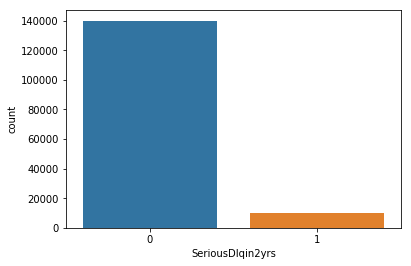

In [15]:
# understanding the target variable

train_df['SeriousDlqin2yrs'].value_counts()

print ('0: ', train_df['SeriousDlqin2yrs'].value_counts()[0] / len(train_df)*100)
print ('1: ', train_df['SeriousDlqin2yrs'].value_counts()[1] / len(train_df)*100)

sns.countplot(train_df['SeriousDlqin2yrs'])

We see that there is an imbalance class in our target variable. We will need to handle this imbalance class issue by either upsampling, downsampling or selecting class_weight: balance (Logistic Regression and Random Forest).

### Age

In [16]:
# checking for any abnormality in age

train_df.age.value_counts()

49     3837
48     3806
50     3753
63     3719
47     3719
46     3714
53     3648
51     3627
52     3609
56     3589
62     3568
54     3561
61     3522
45     3502
58     3443
55     3416
57     3375
44     3294
59     3280
60     3258
43     3208
41     3122
40     3093
42     3082
64     3058
39     2987
38     2631
65     2594
37     2521
67     2503
       ... 
24      816
81      774
82      647
23      641
83      512
85      483
84      480
22      434
86      407
87      357
88      313
89      276
90      198
21      183
91      154
92       93
93       87
94       47
95       45
96       18
97       17
99        9
98        6
103       3
102       3
101       3
109       2
107       1
105       1
0         1
Name: age, Length: 86, dtype: int64

In [17]:
train_df[train_df['age'] == 0]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_band,age_band_1,MonthlyIncome_1
65695,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0,0,0,6000.0


We will be removing row index 65695 as the age could have been inputted with error at age: 0.

In [18]:
# dropping row as it could be entered in error

train_df.drop(65695, inplace=True)

Text(0,0.5,'Count')

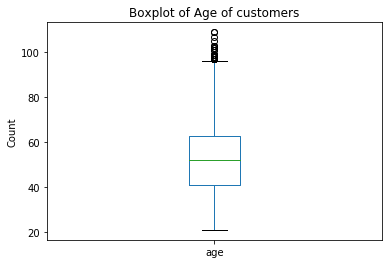

In [19]:
train_df['age'].plot(kind='box')
plt.title('Boxplot of Age of customers')
plt.ylabel('Count')

We can see that there are a handful of outliers in the box plot above. These outliers will not be removed now, till we further explore our dataset.

Text(0.5,1,'Plot of No. of Real Estate Loans or Lines vs Age Band')

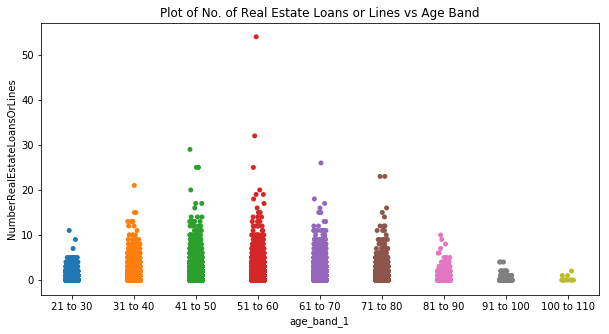

In [20]:
age_band_order = ['21 to 30', '31 to 40', '41 to 50', '51 to 60', '61 to 70', '71 to 80', '81 to 90',
                 '91 to 100', '100 to 110']

plt.figure(figsize=(10,5))
sns.stripplot(x='age_band_1', y='NumberRealEstateLoansOrLines', data=train_df, order=age_band_order)
plt.title('Plot of No. of Real Estate Loans or Lines vs Age Band')

From the above, we see that generally an older person will have more Real Estate Loans or Lines. However, the number of Real Estate Loans or Lines tend to decrease after the age of 60. A possibility could be that the mortgage is fully paid or tenure of loan is completed.

In [21]:
train_df[train_df['NumberRealEstateLoansOrLines']>30]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_band,age_band_1,MonthlyIncome_1
30587,0,0.003032,53,0,5.967504,8000.0,58,0,54,0,0.0,51 to 60,51 to 60,8000.0
104198,0,0.010846,60,0,1.041757,70000.0,38,0,32,0,0.0,51 to 60,51 to 60,70000.0


In [22]:
# dropping the outlier based on the chart above, since it's only 2 customers

train_df.drop(train_df[train_df['NumberRealEstateLoansOrLines'] > 30].index, inplace=True)

### NumberOfDependents

In [23]:
print ('Median Number of Dependents: ', train_df['NumberOfDependents'].median())
print ('Mean Number of Dependents: ', train_df['NumberOfDependents'].mean())

Median Number of Dependents:  0.0
Mean Number of Dependents:  0.7374147482949659


NA would generally mean not applicable, hence it would make sense to input 0 value for NumberOfDependents.

In [24]:
# filling up Number of Dependents with 0

train_df['NumberOfDependents'].fillna(0, inplace=True)

Text(0,0.5,'Count')

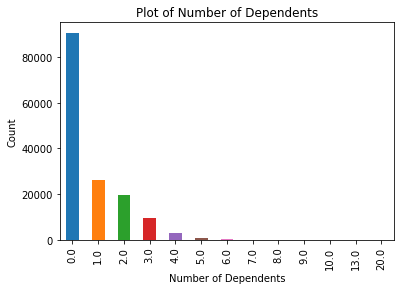

In [25]:
train_df['NumberOfDependents'].value_counts().plot(kind='bar')
plt.title('Plot of Number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Count')

Most of the customers in our dataset have 0 dependents.

Text(0.5,0,'Number of Dependents')

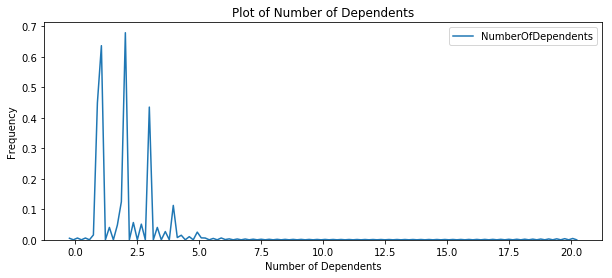

In [26]:
plt.figure(figsize=(10,4))
sns.kdeplot(train_df['NumberOfDependents'])
plt.title('Plot of Number of Dependents')
plt.ylabel('Frequency')
plt.xlabel('Number of Dependents')

In [27]:
outlier_dep = train_df[train_df['NumberOfDependents'] == 20]
train_df.drop(outlier_dep.index, axis=0, inplace=True)

In [28]:
print ('Mean: ', train_df['NumberOfDependents'].mean())
print ('Median: ', train_df['NumberOfDependents'].median())
print ('Std Dev: ', np.std(train_df['NumberOfDependents']))

Mean:  0.7372863276354036
Median:  0.0
Std Dev:  1.1059065576690537


Text(0.5,1,'Plot of No. Of Dependents vs Age')

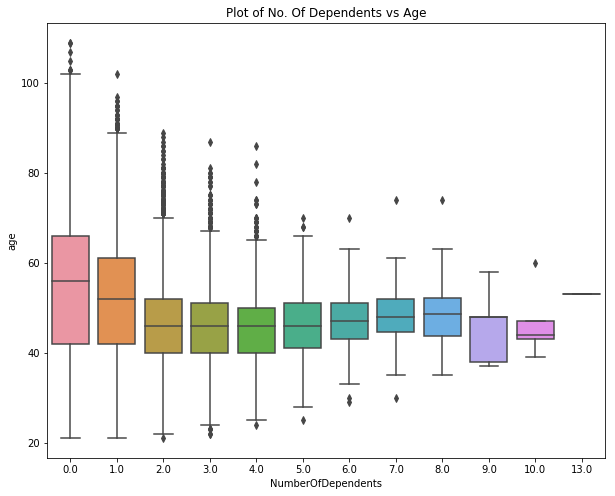

In [29]:
# check age vs number of dependepnts

plt.figure(figsize=(10,8))
sns.boxplot(x='NumberOfDependents', y='age', data=train_df)
plt.title('Plot of No. Of Dependents vs Age')

# sns.jointplot(x='NumberOfDependents', y='age', data=train_df)


We can infer that as a customer age, the number of dependents would increase.

### Monthly Income

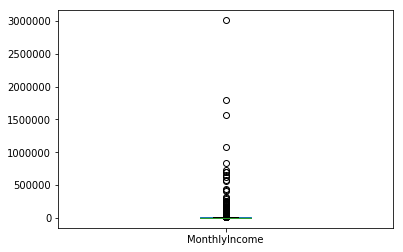

In [30]:
train_df['MonthlyIncome'].plot(kind='box')

In [31]:
# train_df.drop(['age_band', 'MonthlyIncome'], axis=1, inplace=True)

In [32]:
train_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_band,age_band_1,MonthlyIncome_1
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,41 to 50,41 to 50,9120.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,31 to 40,31 to 40,2600.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,31 to 40,31 to 40,3042.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,21 to 30,21 to 30,3300.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,41 to 50,41 to 50,63588.0


Text(0.5,0,'Monthly Income')

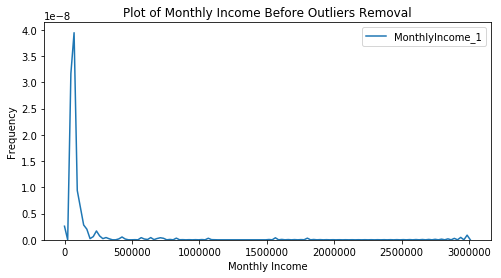

In [33]:
# looking at the distribution of the monthly income of sample before removing outliers

plt.figure(figsize=(8,4))
sns.kdeplot(train_df['MonthlyIncome_1'])
plt.title('Plot of Monthly Income Before Outliers Removal')
plt.ylabel('Frequency')
plt.xlabel('Monthly Income')

In [34]:
print ('Mean: ', train_df['MonthlyIncome_1'].mean())
print ('Median: ', train_df['MonthlyIncome_1'].median())
print ('Std Dev: ', np.std(train_df['MonthlyIncome_1']))

Mean:  6428.862676338035
Median:  5750.0
Std Dev:  12895.548749034742


We will remove those rows that have more than 3 std dev from the median.

In [35]:
std_dev = 3
lower_limit = train_df['MonthlyIncome_1'].median() - (std_dev * np.std(train_df['MonthlyIncome_1']))
upper_limit = train_df['MonthlyIncome_1'].median() + (std_dev * np.std(train_df['MonthlyIncome_1']))

In [36]:
# removing outliers based on Monthly Income.

outlier_income = train_df[train_df['MonthlyIncome_1'] > upper_limit]
train_df.drop(outlier_income.index, axis=0, inplace=True)

Text(0.5,0,'Monthly Income')

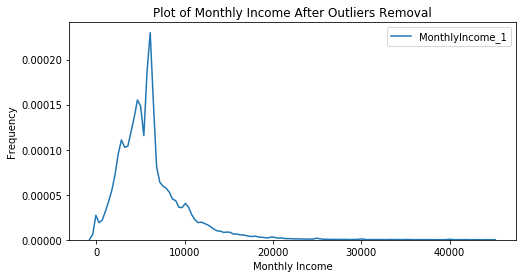

In [37]:
# looking at the distribution of the monthly income of sample after removing outliers

plt.figure(figsize=(8,4))
sns.kdeplot(train_df['MonthlyIncome_1'])
plt.title('Plot of Monthly Income After Outliers Removal')
plt.ylabel('Frequency')
plt.xlabel('Monthly Income')

We observe that the distribution of income is slightly skewed to the right. We will further investigate the Monthly Income of customers against Number of Dependents. <br>In theory, the higher the number of dependents, the more income a customer would require.

Text(0.5,1,'Plot of Monthly Income vs No. of Dependents')

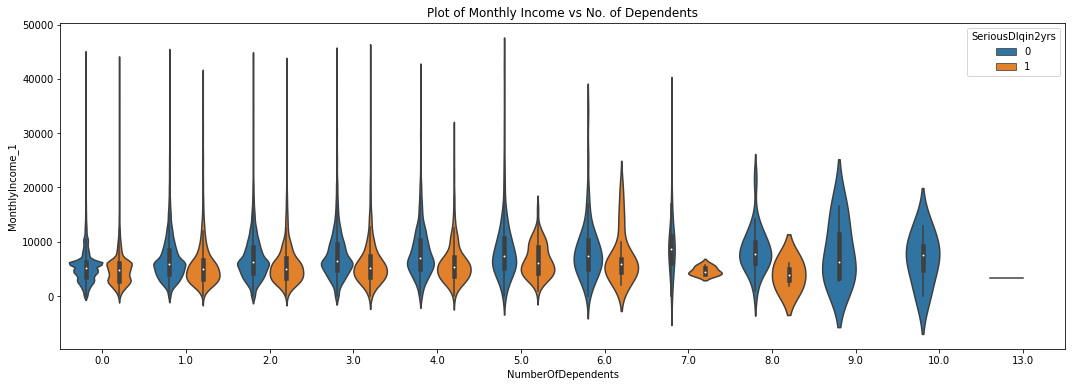

In [38]:
plt.figure(figsize=(18,6))
sns.violinplot(x='NumberOfDependents', y='MonthlyIncome_1', hue='SeriousDlqin2yrs', data=train_df)
plt.title('Plot of Monthly Income vs No. of Dependents')

Based on the plot above, we observe that a customers who are prone to deliquent in 2 years generally have lesser monthly income compared to their counterparts in the same no. of dependents spectrum. <br>
We also observe that generally, the higher the number of dependents, the higher the income of the person by looking at the violin plot above.

Text(0.5,1,'Plot of Age Band vs Monthly Income')

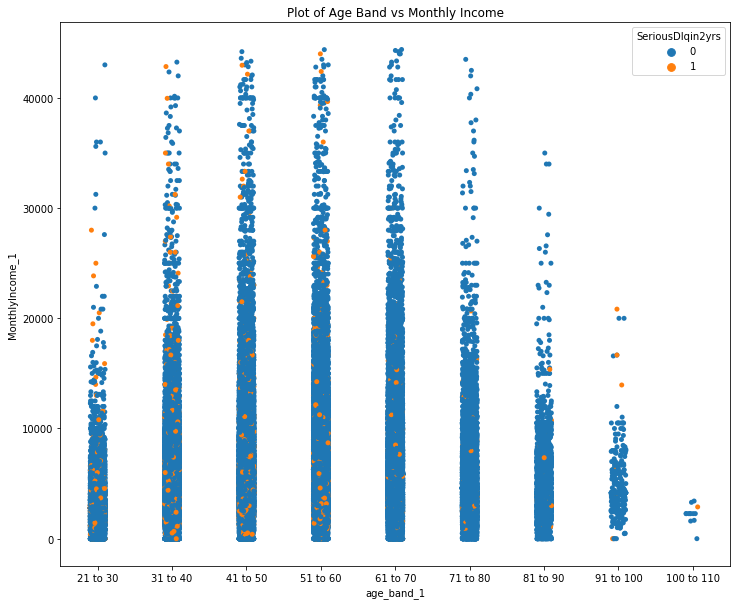

In [39]:
plt.figure(figsize=(12,10))
sns.stripplot(x='age_band_1', y='MonthlyIncome_1', data=train_df, order=age_band_order, hue='SeriousDlqin2yrs')
plt.title('Plot of Age Band vs Monthly Income')

We can see that generally monthly income increases as you grow older and have more working experience, untill the after 70 years old (approx retirement age), where monthly income reduces. We observe there are more delinquencies below the ageband of 61 to 70.

In [40]:
train_df[(train_df['MonthlyIncome_1']==0) & (train_df['SeriousDlqin2yrs'] == 1)]#['age_band_1'].value_counts()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_band,age_band_1,MonthlyIncome_1
4534,1,0.798359,45,0,185.0,0.0,5,0,0,1,3.0,41 to 50,41 to 50,0.0
7221,1,1.000000,29,0,494.0,0.0,2,0,0,0,0.0,21 to 30,21 to 30,0.0
8289,1,1.000000,37,1,2486.0,0.0,7,1,1,1,4.0,31 to 40,31 to 40,0.0
8505,1,0.641294,47,1,684.0,0.0,5,5,0,5,0.0,41 to 50,41 to 50,0.0
9879,1,1.000000,63,2,1031.0,0.0,7,2,2,0,0.0,61 to 70,61 to 70,0.0
13164,1,1.000000,46,0,0.0,0.0,0,2,0,0,3.0,41 to 50,41 to 50,0.0
19919,1,0.040224,57,0,2945.0,0.0,10,0,1,0,0.0,51 to 60,51 to 60,0.0
24682,1,0.962681,57,3,14969.0,0.0,15,1,8,2,3.0,51 to 60,51 to 60,0.0
25087,1,1.071785,46,3,6243.0,0.0,9,4,2,0,0.0,41 to 50,41 to 50,0.0
29285,1,0.312819,47,2,5497.0,0.0,24,0,2,0,2.0,41 to 50,41 to 50,0.0


### DebtRatio

In [41]:
train_df.DebtRatio.max()

329664.0

In [42]:
train_df[train_df['DebtRatio'] > 300000]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_band,age_band_1,MonthlyIncome_1
36600,0,0.001782,65,0,326442.0,NaN,6,0,1,0,0.0,61 to 70,61 to 70,5833.0
60152,0,0.000000,65,0,329664.0,NaN,9,0,3,0,0.0,61 to 70,61 to 70,5833.0
127047,0,0.034290,58,1,307001.0,NaN,16,0,4,0,2.0,51 to 60,51 to 60,6307.5


Text(0.5,1,'No. of Time 30-59 Days Late vs Debt Ratio')

<Figure size 288x288 with 0 Axes>

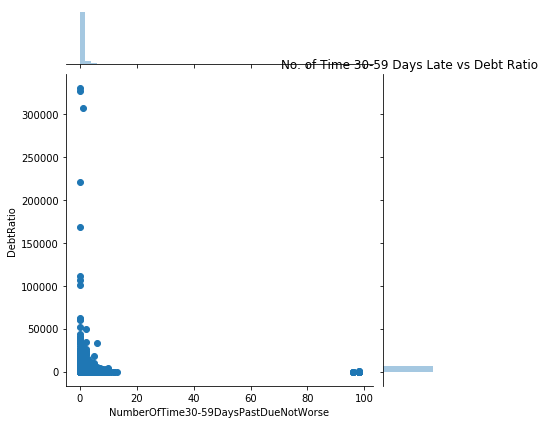

In [43]:
plt.figure(figsize=(4,4))
sns.jointplot(x='NumberOfTime30-59DaysPastDueNotWorse', y='DebtRatio', data=train_df)
plt.title('No. of Time 30-59 Days Late vs Debt Ratio')

Text(0.5,1,'No. of Time 90 Days Late vs Debt Ratio')

<Figure size 576x576 with 0 Axes>

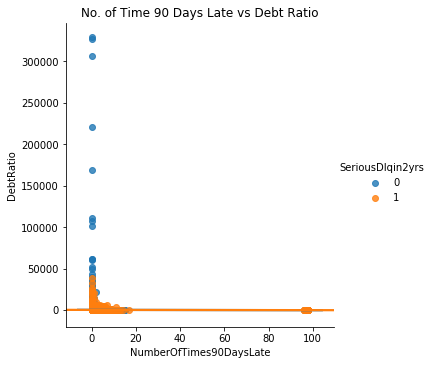

In [44]:
plt.figure(figsize=(8,8))
sns.lmplot(x='NumberOfTimes90DaysLate', y='DebtRatio', data=train_df, hue='SeriousDlqin2yrs')
plt.title('No. of Time 90 Days Late vs Debt Ratio')

In [45]:
# a high Percentage of customers face serious deliquency if they have been in deliquency between 30 -59 days
print ('Percentage of Person facing Serious Deliq in 30 - 59 days: ', float(train_df[(train_df['NumberOfTime30-59DaysPastDueNotWorse'] > 80) & (train_df['SeriousDlqin2yrs'] == 1)].shape[0]) / train_df[train_df['NumberOfTime30-59DaysPastDueNotWorse'] >80].shape[0])

Percentage of Person facing Serious Deliq in 30 - 59 days:  0.5464684014869888


Text(0.5,1,'No. of Time 60-89 Days Late vs Debt Ratio')

<Figure size 576x576 with 0 Axes>

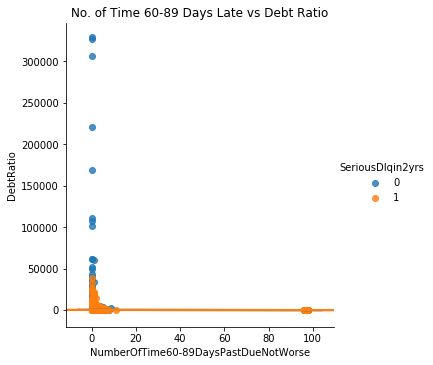

In [46]:
plt.figure(figsize=(8,8))
sns.lmplot(x='NumberOfTime60-89DaysPastDueNotWorse', y='DebtRatio', data=train_df,  hue='SeriousDlqin2yrs')
plt.title('No. of Time 60-89 Days Late vs Debt Ratio')

In [47]:
print ('Percentage of Deliquency if late for 60 - 89 days: ',float(train_df[(train_df['NumberOfTime60-89DaysPastDueNotWorse']>80) & (train_df['SeriousDlqin2yrs'] ==1)].shape[0]) / float(train_df[train_df['NumberOfTime60-89DaysPastDueNotWorse']>80].shape[0]))

Percentage of Deliquency if late for 60 - 89 days:  0.5464684014869888


Text(0.5,1,'No. of Time 90 Days Late vs Debt Ratio')

<Figure size 576x576 with 0 Axes>

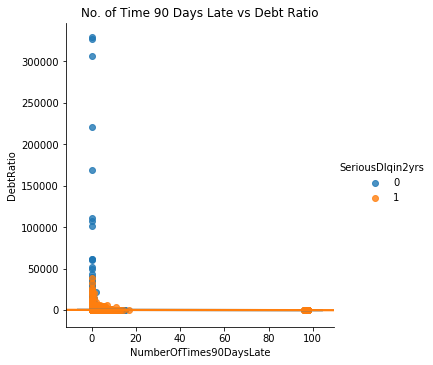

In [48]:
plt.figure(figsize=(8,8))
sns.lmplot(x='NumberOfTimes90DaysLate', y='DebtRatio', data=train_df, hue='SeriousDlqin2yrs')
plt.title('No. of Time 90 Days Late vs Debt Ratio')

In [49]:
print ('Percentage of Deliquency if late for 90 days or more: ',float(train_df[(train_df['NumberOfTimes90DaysLate']>80) & (train_df['SeriousDlqin2yrs'] ==1)].shape[0]) / float(train_df[train_df['NumberOfTimes90DaysLate']>80].shape[0]))

Percentage of Deliquency if late for 90 days or more:  0.5464684014869888


In [50]:
train_df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

0     142037
1       5714
2       1117
3        318
98       264
4        104
5         34
6         16
7          9
96         5
8          2
11         1
9          1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [51]:
train_df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

0     125709
1      15988
2       4585
3       1748
4        745
5        341
98       264
6        138
7         54
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

In [52]:
train_df['NumberOfTimes90DaysLate'].value_counts()

0     141307
1       5229
2       1551
3        663
4        291
98       264
5        130
6         80
7         38
8         21
9         19
10         8
11         5
96         5
13         4
12         2
14         2
15         2
17         1
Name: NumberOfTimes90DaysLate, dtype: int64

Text(0.5,1,'No. of Times 90 Days Late vs No. of Times 60-89 Days Late')

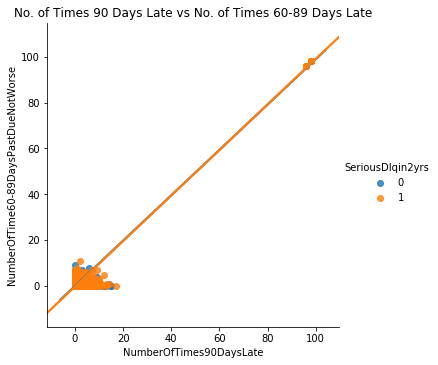

In [53]:
sns.lmplot('NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', train_df, hue='SeriousDlqin2yrs')
plt.title('No. of Times 90 Days Late vs No. of Times 60-89 Days Late')

Text(0.5,1,'No. of Times 90 Days Late vs No. of Times 30-59 Days Late')

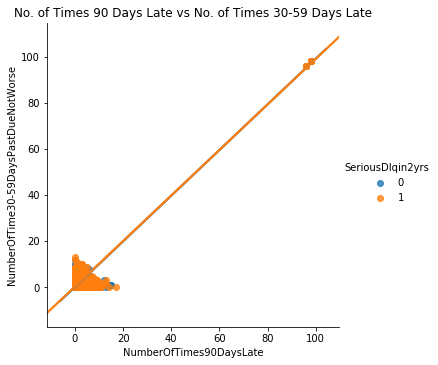

In [54]:
sns.lmplot('NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', train_df,  hue='SeriousDlqin2yrs')
plt.title('No. of Times 90 Days Late vs No. of Times 30-59 Days Late')

Text(0.5,1,'No. of Times 60-89 Days Late vs No. of Times 30-59 Days Late')

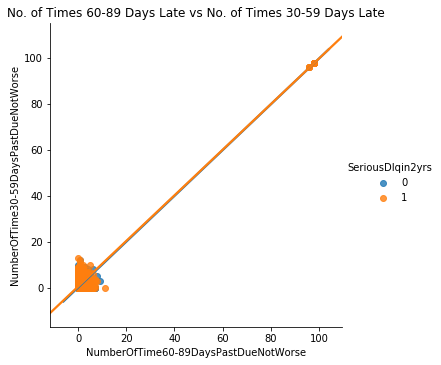

In [55]:
sns.lmplot('NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse', train_df,  hue='SeriousDlqin2yrs')
plt.title('No. of Times 60-89 Days Late vs No. of Times 30-59 Days Late')

### Preparing X and y variables

In [56]:
X = train_df.drop(['SeriousDlqin2yrs', 'age_band_1', 'age_band', 'MonthlyIncome'], axis=1)
y = train_df['SeriousDlqin2yrs']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
ss = StandardScaler()

# standard scaling for X_train and X_test
ss.fit(X_train)
Xs_train = ss.transform(X_train)

Xs_test = ss.transform(X_test)

In [59]:
print (y_train.value_counts())
print ('0: ', y_train.value_counts()[0] / len(train_df))
print ('1: ', y_train.value_counts()[1] / len(train_df))

0    111715
1      7982
Name: SeriousDlqin2yrs, dtype: int64
0:  0.7466482201815241
1:  0.05334776971301012


In [60]:
print (y_test.value_counts())
print ('0: ', y_test.value_counts()[0] / len(train_df))
print ('1: ', y_test.value_counts()[1] / len(train_df))

0    27904
1     2021
Name: SeriousDlqin2yrs, dtype: int64
0:  0.18649663819491785
1:  0.013507371910547914


### Upsampling

In [61]:
temp_df = pd.concat([X_train, y_train], axis=1)

In [62]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = temp_df[temp_df['SeriousDlqin2yrs'] == 0]
df_minority = temp_df[temp_df['SeriousDlqin2yrs'] == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=y_train.value_counts()[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
temp_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
temp_upsampled.SeriousDlqin2yrs.value_counts()

1    111715
0    111715
Name: SeriousDlqin2yrs, dtype: int64

In [63]:
X_train_up = temp_upsampled.drop('SeriousDlqin2yrs', axis=1)
y_train_up = temp_upsampled['SeriousDlqin2yrs']

In [64]:
ss_up = StandardScaler()

# standard scaling for X_train and X_test
ss_up.fit(X_train_up)
Xs_train_up = ss_up.transform(X_train_up)

Xs_test_up = ss_up.transform(X_test)

### Downsampling

In [65]:
# Separate majority and minority classes
df_majority_ds = temp_df[temp_df['SeriousDlqin2yrs'] == 0]  # for ref
df_minority_ds = temp_df[temp_df['SeriousDlqin2yrs'] == 1]  # for ref
 
# Downsample majority class
df_majority_downsampled = resample(df_majority_ds, 
                                 replace=True,     # sample with replacement
                                 n_samples=y_train.value_counts()[1],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
temp_downsampled = pd.concat([df_minority_ds, df_majority_downsampled])
 
# Display new class counts
temp_downsampled.SeriousDlqin2yrs.value_counts()

1    7982
0    7982
Name: SeriousDlqin2yrs, dtype: int64

In [66]:
X_train_ds = temp_downsampled.drop('SeriousDlqin2yrs', axis=1)
y_train_ds = temp_downsampled['SeriousDlqin2yrs']

In [67]:
ss_ds = StandardScaler()

# standard scaling for X_train and X_test
ss_ds.fit(X_train_ds)
Xs_train_ds = ss_ds.transform(X_train_ds)

Xs_test_ds = ss_ds.transform(X_test)

## Modelling

### Functions for modelling

In [68]:
classification_print = ('-'* 20 + 'Classification Report' + '-'*20)
cm_print = ('-'* 20 + 'Confusion Matrix' + '-'*20)

In [69]:
# AUC Plot Function

# write function to get model performance
def model_performance(model, X_test, y_test):
#     model.fit(X_train_q2, y_train_q2)
    Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
    # roc, auc for model for common performance measurement
    
    # For class 1, find the area under the curve.
    fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
    roc_auc = auc(fpr, tpr)
    
    # Plot of a ROC curve.
    plt.figure(figsize=[4,4])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for Model', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    print ('Auc:',roc_auc)

In [70]:
# Confusion Matrix Function

classes = set(y_train)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bayes

#### Bernoulli Naive Bayes

Cross-Val Score:  0.9300400901403709
Score: 0.9288220551378447 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.95      0.97      0.96     27904
          1       0.46      0.29      0.36      2021

avg / total       0.92      0.93      0.92     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[27206   698]
 [ 1432   589]]


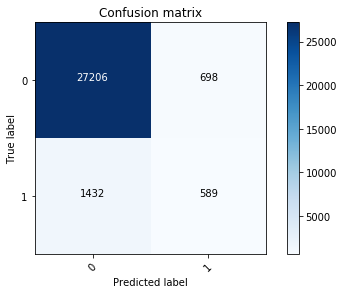

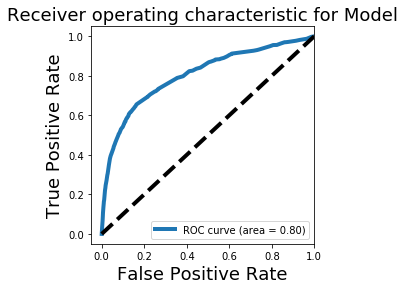

Auc: 0.8037822527310714


In [71]:
rfc = RandomForestClassifier(class_weight='balanced')


bnb = BernoulliNB()


# 10-Fold Cross validation
print ('Cross-Val Score: ', np.mean(cross_val_score(bnb, Xs_train, y_train, cv=10)))



# fitting the model
bnb.fit(Xs_train, y_train)    
score_model = bnb.score(Xs_test, y_test)


# print score of model
print ('Score: {}' .format(score_model), '\n')


# predicting model
predict_model = bnb.predict(Xs_test)


print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, predict_model), '\n')
print (cm_print, '\n')

cm_model = confusion_matrix(y_test, predict_model)


plot_confusion_matrix(cm_model, classes)

# plotting AUC Curve
model_performance(bnb, Xs_test, y_test)

#### NB - Upsampled

In [72]:
bnb_gs_up = BernoulliNB()

param = {'alpha':[0.001, 0.01, 1, 10]}
 
grid_gs_bnb_up = GridSearchCV(bnb_gs_up, param, verbose=2, cv=10)

# fit model
grid_gs_bnb_up.fit(Xs_train_up, y_train_up)

grid_gs_bnb_up.best_params_
model_gs_bnb_up = grid_gs_bnb_up.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    7.0s finished


Score: 0.813968253968254 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.96      0.83      0.89     27904
          1       0.20      0.58      0.30      2021

avg / total       0.91      0.81      0.85     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[23180  4724]
 [  843  1178]]


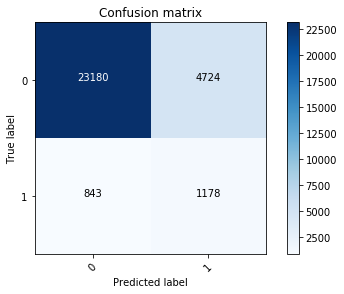

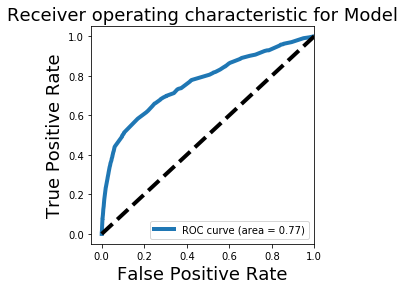

Auc: 0.7657422022178818


In [73]:
# score model
score_gs_bnb_up = model_gs_bnb_up.score(Xs_test_up, y_test)

print ('Score: {}' .format(score_gs_bnb_up), '\n')


pred_gs_bnb_up = model_gs_bnb_up.predict(Xs_test_up)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_gs_bnb_up), '\n')
print (cm_print, '\n')

cm_gs_bnb_up = confusion_matrix(y_test, pred_gs_bnb_up)

plot_confusion_matrix(cm_gs_bnb_up, classes)


# Plotting AUC Curve
model_performance(model_gs_bnb_up, Xs_test_up, y_test)

In [74]:
# getting the features

gs_bnb_coef = [item for sublist in model_gs_bnb_up.coef_ for item in sublist]
feat = []
for feature in zip(list(X_train.columns.values), gs_bnb_coef):
    feat.append(feature)
    
feat_df_bnb = pd.DataFrame(feat, columns=['Feature', 'Coef'])
feat_df_bnb.sort_values('Coef', ascending=False)

,Feature,Coef
6,NumberRealEstateLoansOrLines,-0.632947
8,NumberOfDependents,-0.739969
4,NumberOfOpenCreditLinesAndLoans,-0.924356
9,MonthlyIncome_1,-0.967120
1,age,-0.978199
7,NumberOfTime60-89DaysPastDueNotWorse,-1.290988
2,NumberOfTime30-59DaysPastDueNotWorse,-1.348662
5,NumberOfTimes90DaysLate,-1.759814
3,DebtRatio,-2.096547
0,RevolvingUtilizationOfUnsecuredLines,-6.330580


#### NB Downsampled

In [75]:
# For GridSearch Downsampling

bnb_gs_ds = BernoulliNB()

param = {'alpha':[0.001, 0.01, 1, 10]}
 

grid_bnb_ds = GridSearchCV(bnb_gs_ds, param, verbose=1, cv=10)

# fit model
grid_bnb_ds.fit(Xs_train_ds, y_train_ds)

grid_bnb_ds.best_params_
model_bnb_gs_ds = grid_bnb_ds.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


Score: 0.7632080200501253 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.96      0.78      0.86     27904
          1       0.16      0.59      0.25      2021

avg / total       0.91      0.76      0.82     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[21647  6257]
 [  829  1192]]


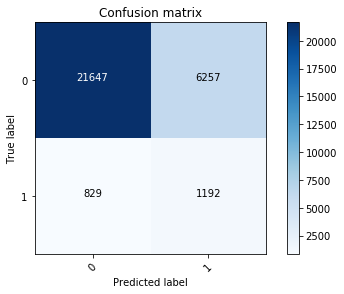

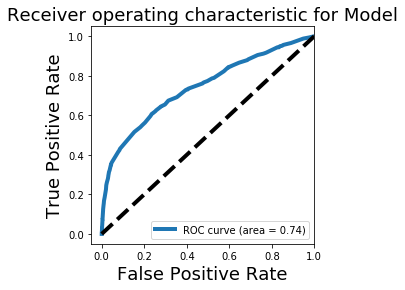

Auc: 0.7417355812279551


In [76]:
# score model
score_gs_bnb_ds = model_bnb_gs_ds.score(Xs_test_ds, y_test)

print ('Score: {}' .format(score_gs_bnb_ds), '\n')


pred_bnb_gs_ds = model_bnb_gs_ds.predict(Xs_test_ds)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_bnb_gs_ds), '\n')
print (cm_print, '\n')

cm_bnb_gs_ds = confusion_matrix(y_test, pred_bnb_gs_ds)

plot_confusion_matrix(cm_bnb_gs_ds, classes)


# Plotting AUC Curve

model_performance(model_bnb_gs_ds, Xs_test_ds, y_test)

In [77]:
# getting the features

gs_bnb_ds_coef = [item for sublist in model_bnb_gs_ds.coef_ for item in sublist]
feat = []
for feature in zip(list(X_train.columns.values), gs_bnb_ds_coef):
    feat.append(feature)
    
feat_df_bnb_ds = pd.DataFrame(feat, columns=['Feature', 'Coef'])
feat_df_bnb_ds.sort_values('Coef', ascending=False)

,Feature,Coef
6,NumberRealEstateLoansOrLines,-0.631447
8,NumberOfDependents,-0.741662
4,NumberOfOpenCreditLinesAndLoans,-0.924720
9,MonthlyIncome_1,-0.953559
1,age,-0.977244
2,NumberOfTime30-59DaysPastDueNotWorse,-1.350123
5,NumberOfTimes90DaysLate,-1.755830
3,DebtRatio,-2.100457
7,NumberOfTime60-89DaysPastDueNotWorse,-2.301582
0,RevolvingUtilizationOfUnsecuredLines,-6.499955


### Logistic Regression

#### Logistic Regression CV

In [78]:
lrcv = LogisticRegressionCV(class_weight='balanced', cv=10, penalty='l2', solver='liblinear') #liblinear

#fit model
lrcv.fit(Xs_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

Accuracy Score: 0.7698913951545531 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.78      0.86     27904
          1       0.17      0.65      0.28      2021

avg / total       0.91      0.77      0.82     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[21732  6172]
 [  714  1307]]


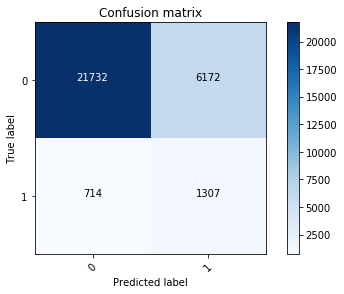

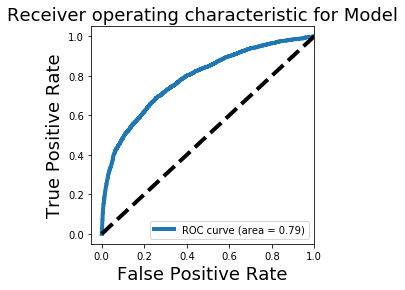

Auc: 0.7871829200788509


In [79]:
# score model
score_lrcv = lrcv.score(Xs_test, y_test)

print ('Accuracy Score: {}' .format(score_lrcv), '\n')

# predict
pred_lrcv = lrcv.predict(Xs_test)

cm_lrcv = confusion_matrix(y_test, pred_lrcv)

print (classification_print, '\n')

print ('Classification report: \n', classification_report(y_test, pred_lrcv), '\n')

print (cm_print, '\n')

plot_confusion_matrix(cm_lrcv, classes)


# Plotting AUC Curve
model_performance(lrcv, Xs_test, y_test)

In [80]:
# getting the features

lrcv_coef = [item for sublist in lrcv.coef_ for item in sublist]
feat = []
for feature in zip(list(X_train.columns.values), lrcv_coef):
    feat.append(feature)
    
feat_df_rfc = pd.DataFrame(feat, columns=['Feature', 'Coef'])
feat_df_rfc.sort_values('Coef', ascending=False)

,Feature,Coef
2,NumberOfTime30-59DaysPastDueNotWorse,2.221920
5,NumberOfTimes90DaysLate,2.141545
6,NumberRealEstateLoansOrLines,0.091697
8,NumberOfDependents,0.089859
7,NumberOfTime60-89DaysPastDueNotWorse,0.075158
4,NumberOfOpenCreditLinesAndLoans,0.013519
0,RevolvingUtilizationOfUnsecuredLines,-0.005796
3,DebtRatio,-0.080394
9,MonthlyIncome_1,-0.183699
1,age,-0.438424


#### Logistic Regression GridSearch

In [81]:
# defining model and params

lr_gs = LogisticRegression(class_weight='balanced')

# param_grid_lr_gs = {'penalty':['l1', 'l2'],
#                     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
#                    }

param = {'solver':['liblinear', 'lbfgs', 'newton-cg'],
         'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
        }
    
# fit gridsearch with model, param_grid, cv_tir
grid_lr_gs = GridSearchCV(lr_gs, param, verbose=2, cv=10)

#fit model
grid_lr_gs.fit(Xs_train, y_train)

# get best param
grid_lr_gs.best_params_
model_lr_gs = grid_lr_gs.best_estimator_

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] 

D:\GA\Anaconda\envs\py3.6\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\GA\Anaconda\envs\py3.6\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ....................... C=0.0001, solver=newton-cg, total=   0.7s
[CV] C=0.0001, solver=newton-cg ......................................
[CV] ....................... C=0.0001, solver=newton-cg, total=   0.2s
[CV] C=0.0001, solver=newton-cg ......................................
[CV] ....................... C=0.0001, solver=newton-cg, total=   0.2s
[CV] C=0.0001, solver=newton-cg ......................................
[CV] ....................... C=0.0001, solver=newton-cg, total=   0.2s
[CV] C=0.0001, solver=newton-cg ......................................
[CV] ....................... C=0.0001, solver=newton-cg, total=   0.2s
[CV] C=0.0001, solver=newton-cg ......................................
[CV] ....................... C=0.0001, solver=newton-cg, total=   0.2s
[CV] C=0.001, solver=liblinear .......................................
[CV] ........................ C=0.001, solver=liblinear, total=   0.2s
[CV] C=0.001, solver=liblinear .......................................
[CV] .

D:\GA\Anaconda\envs\py3.6\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\GA\Anaconda\envs\py3.6\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ........................ C=0.001, solver=newton-cg, total=   0.8s
[CV] C=0.001, solver=newton-cg .......................................
[CV] ........................ C=0.001, solver=newton-cg, total=   0.3s
[CV] C=0.001, solver=newton-cg .......................................
[CV] ........................ C=0.001, solver=newton-cg, total=   0.3s
[CV] C=0.001, solver=newton-cg .......................................
[CV] ........................ C=0.001, solver=newton-cg, total=   0.3s
[CV] C=0.001, solver=newton-cg .......................................
[CV] ........................ C=0.001, solver=newton-cg, total=   0.3s
[CV] C=0.001, solver=newton-cg .......................................
[CV] ........................ C=0.001, solver=newton-cg, total=   0.3s
[CV] C=0.001, solver=newton-cg .......................................
[CV] ........................ C=0.001, solver=newton-cg, total=   0.3s
[CV] C=0.001, solver=newton-cg .......................................
[CV] .

D:\GA\Anaconda\envs\py3.6\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\GA\Anaconda\envs\py3.6\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ......................... C=0.01, solver=newton-cg, total=   0.9s
[CV] C=0.01, solver=newton-cg ........................................
[CV] ......................... C=0.01, solver=newton-cg, total=   0.3s
[CV] C=0.01, solver=newton-cg ........................................
[CV] ......................... C=0.01, solver=newton-cg, total=   0.3s
[CV] C=0.01, solver=newton-cg ........................................
[CV] ......................... C=0.01, solver=newton-cg, total=   0.3s
[CV] C=0.01, solver=newton-cg ........................................
[CV] ......................... C=0.01, solver=newton-cg, total=   0.4s
[CV] C=0.1, solver=liblinear .........................................
[CV] .......................... C=0.1, solver=liblinear, total=   0.2s
[CV] C=0.1, solver=liblinear .........................................
[CV] .......................... C=0.1, solver=liblinear, total=   0.2s
[CV] C=0.1, solver=liblinear .........................................
[CV] .

D:\GA\Anaconda\envs\py3.6\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\GA\Anaconda\envs\py3.6\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] .......................... C=0.1, solver=newton-cg, total=   1.1s
[CV] C=0.1, solver=newton-cg .........................................
[CV] .......................... C=0.1, solver=newton-cg, total=   0.3s
[CV] C=0.1, solver=newton-cg .........................................
[CV] .......................... C=0.1, solver=newton-cg, total=   1.0s
[CV] C=0.1, solver=newton-cg .........................................
[CV] .......................... C=0.1, solver=newton-cg, total=   0.4s
[CV] C=0.1, solver=newton-cg .........................................
[CV] .......................... C=0.1, solver=newton-cg, total=   0.4s
[CV] C=1, solver=liblinear ...........................................
[CV] ............................ C=1, solver=liblinear, total=   0.2s
[CV] C=1, solver=liblinear ...........................................
[CV] ............................ C=1, solver=liblinear, total=   0.2s
[CV] C=1, solver=liblinear ...........................................
[CV] .

D:\GA\Anaconda\envs\py3.6\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\GA\Anaconda\envs\py3.6\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV] ............................ C=1, solver=newton-cg, total=   0.6s
[CV] C=1, solver=newton-cg ...........................................
[CV] ............................ C=1, solver=newton-cg, total=   0.4s
[CV] C=10, solver=liblinear ..........................................
[CV] ........................... C=10, solver=liblinear, total=   0.2s
[CV] C=10, solver=liblinear ..........................................
[CV] ........................... C=10, solver=liblinear, total=   0.3s
[CV] C=10, solver=liblinear ..........................................
[CV] ........................... C=10, solver=liblinear, total=   0.2s
[CV] C=10, solver=liblinear ..........................................
[CV] ........................... C=10, solver=liblinear, total=   0.3s
[CV] C=10, solver=liblinear ..........................................
[CV] ........................... C=10, solver=liblinear, total=   0.2s
[CV] C=10, solver=liblinear ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.0min finished


Accuracy Score: 0.7698913951545531 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.78      0.86     27904
          1       0.17      0.65      0.28      2021

avg / total       0.91      0.77      0.82     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[21732  6172]
 [  714  1307]]


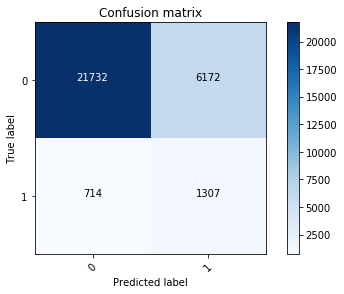

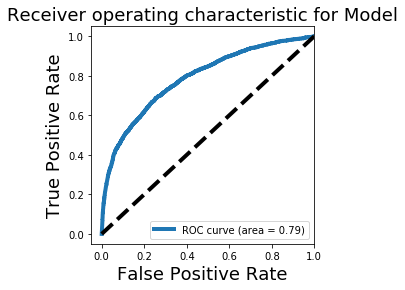

Auc: 0.7871804730093195


In [82]:
# score model
score_lr_gs = model_lr_gs.score(Xs_test, y_test)

print ('Accuracy Score: {}' .format(score_lr_gs), '\n')

pred_lr_gs = model_lr_gs.predict(Xs_test)

cm_lr_gs = confusion_matrix(y_test, pred_lr_gs)

print (classification_print, '\n')

print ('Classification report: \n', classification_report(y_test, pred_lr_gs), '\n')

print (cm_print, '\n')

plot_confusion_matrix(cm_lr_gs, classes)


# Plotting AUC Curve
model_performance(model_lr_gs, Xs_test, y_test)

In [83]:
# getting the features

lrcv_coef = [item for sublist in model_lr_gs.coef_ for item in sublist]
feat = []
for feature in zip(list(X_train.columns.values), lrcv_coef):
    feat.append(feature)
    
feat_df_rfc = pd.DataFrame(feat, columns=['Feature', 'Coef'])
feat_df_rfc.sort_values('Coef', ascending=False)

,Feature,Coef
2,NumberOfTime30-59DaysPastDueNotWorse,2.221709
5,NumberOfTimes90DaysLate,2.141191
6,NumberRealEstateLoansOrLines,0.091695
8,NumberOfDependents,0.089861
7,NumberOfTime60-89DaysPastDueNotWorse,0.075324
4,NumberOfOpenCreditLinesAndLoans,0.013514
0,RevolvingUtilizationOfUnsecuredLines,-0.005797
3,DebtRatio,-0.080394
9,MonthlyIncome_1,-0.183699
1,age,-0.438422


#### Logistic Regression GridSearch Upsample

In [84]:
# param = {'penalty':['l1', 'l2'],
#          'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
#         }

lr_up = LogisticRegression()

param = {'solver':['liblinear', 'lbfgs', 'newton-cg'],
         'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
        }
 
grid_gs_lr_up = GridSearchCV(lr_up, param, verbose=2, cv=5)

# fit model
grid_gs_lr_up.fit(Xs_train_up, y_train_up)

grid_gs_lr_up.best_params_
model_gs_lr_up = grid_gs_lr_up.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.2s
[CV] C=0.0001, solver=liblinear ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.2s
[CV] C=0.0001, solver=liblinear ......................................
[CV] ....................... C=0.0001, solver=liblinear, total=   0.1s
[CV] C=0.0001, solver=lbfgs ..........................................
[CV] ........................... C=0.0001, solver=lbfgs, total=   0.0s
[CV] C=0.0001, solver=lbfgs ..........................................
[CV] ........................... C=0.0001, solver=lbfgs, total=   0.1s
[CV] C=0.0001, solver=lbfgs ..........................................
[CV] ........................... C=0.0001, solver=lbfgs, total=   0.1s
[CV] C=0.0001, solver=lbfgs ..........................................
[CV] .

[CV] .......................... C=0.1, solver=newton-cg, total=   0.9s
[CV] C=1, solver=liblinear ...........................................
[CV] ............................ C=1, solver=liblinear, total=   0.4s
[CV] C=1, solver=liblinear ...........................................
[CV] ............................ C=1, solver=liblinear, total=   0.4s
[CV] C=1, solver=liblinear ...........................................
[CV] ............................ C=1, solver=liblinear, total=   0.5s
[CV] C=1, solver=liblinear ...........................................
[CV] ............................ C=1, solver=liblinear, total=   0.4s
[CV] C=1, solver=liblinear ...........................................
[CV] ............................ C=1, solver=liblinear, total=   0.4s
[CV] C=1, solver=lbfgs ...............................................
[CV] ................................ C=1, solver=lbfgs, total=   0.3s
[CV] C=1, solver=lbfgs ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   56.7s finished


Score: 0.7697243107769424 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.78      0.86     27904
          1       0.17      0.65      0.27      2021

avg / total       0.91      0.77      0.82     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[21728  6176]
 [  715  1306]]


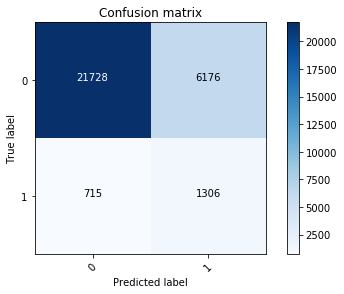

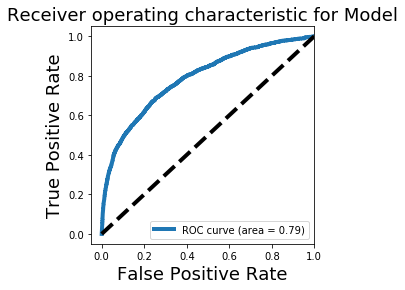

Auc: 0.7870184521809986


In [85]:
# score model
score_gs_lr_up = model_gs_lr_up.score(Xs_test_up, y_test)

print ('Score: {}' .format(score_gs_lr_up), '\n')


pred_gs_lr_up = model_gs_lr_up.predict(Xs_test_up)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_gs_lr_up), '\n')
print (cm_print, '\n')

cm_gs_lr_up = confusion_matrix(y_test, pred_gs_lr_up)

plot_confusion_matrix(cm_gs_lr_up, classes)


# Plotting AUC Curve
model_performance(model_gs_lr_up, Xs_test_up, y_test)

In [86]:
# getting the features

lrcv_coef = [item for sublist in model_gs_lr_up.coef_ for item in sublist]
feat = []
for feature in zip(list(X_train.columns.values), lrcv_coef):
    feat.append(feature)
    
feat_df_rfc = pd.DataFrame(feat, columns=['Feature', 'Coef'])
feat_df_rfc.sort_values('Coef', ascending=False)

,Feature,Coef
2,NumberOfTime30-59DaysPastDueNotWorse,4.565758
5,NumberOfTimes90DaysLate,4.380155
7,NumberOfTime60-89DaysPastDueNotWorse,0.143756
8,NumberOfDependents,0.096984
6,NumberRealEstateLoansOrLines,0.096797
4,NumberOfOpenCreditLinesAndLoans,0.015055
0,RevolvingUtilizationOfUnsecuredLines,-0.004043
3,DebtRatio,-0.063373
9,MonthlyIncome_1,-0.169317
1,age,-0.425331


#### Logistic Regression GridSearch Downsample

In [87]:
param = {'solver':['liblinear', 'lbfgs', 'newton-cg'],
         'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
        }

lr_ds = LogisticRegression()


# For GridSearch Downsampling
    
#fit gridsearch with model, param_grid, cv_itr
grid_lr_ds = GridSearchCV(lr_ds, param, verbose=1, cv=10)

# fit model
grid_lr_ds.fit(Xs_train_ds, y_train_ds)

grid_lr_ds.best_params_
model_lr_gs_ds = grid_lr_ds.best_estimator_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    5.6s finished


Score: 0.7130492898913952 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.72      0.82     27904
          1       0.14      0.64      0.23      2021

avg / total       0.91      0.71      0.78     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[20041  7863]
 [  724  1297]]


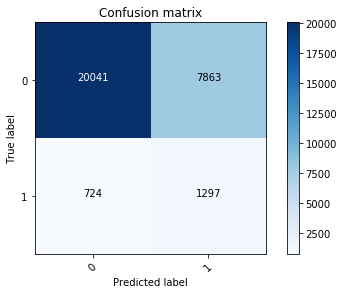

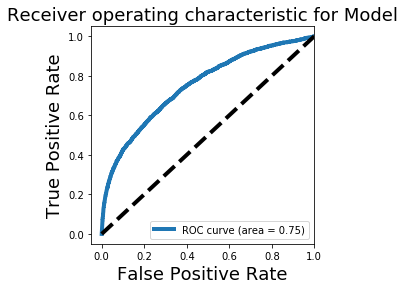

Auc: 0.7515498993651522


In [88]:
# score model
score_gs_lr_ds = model_lr_gs_ds.score(Xs_test_ds, y_test)

print ('Score: {}' .format(score_gs_lr_ds), '\n')


pred_lr_gs_ds = model_lr_gs_ds.predict(Xs_test_ds)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_lr_gs_ds), '\n')
print (cm_print, '\n')

cm_lr_gs_ds = confusion_matrix(y_test, pred_lr_gs_ds)

plot_confusion_matrix(cm_lr_gs_ds, classes)


# Plotting AUC Curve

model_performance(model_lr_gs_ds, Xs_test_ds, y_test)

In [89]:
# getting the features

lrcv_coef = [item for sublist in model_lr_gs_ds.coef_ for item in sublist]
feat = []
for feature in zip(list(X_train.columns.values), lrcv_coef):
    feat.append(feature)
    
feat_df_rfc = pd.DataFrame(feat, columns=['Feature', 'Coef'])
feat_df_rfc.sort_values('Coef', ascending=False)

,Feature,Coef
2,NumberOfTime30-59DaysPastDueNotWorse,3.857773
5,NumberOfTimes90DaysLate,2.770268
8,NumberOfDependents,0.121768
6,NumberRealEstateLoansOrLines,0.076674
4,NumberOfOpenCreditLinesAndLoans,0.014036
0,RevolvingUtilizationOfUnsecuredLines,-0.033203
3,DebtRatio,-0.041913
9,MonthlyIncome_1,-0.164692
1,age,-0.413621
7,NumberOfTime60-89DaysPastDueNotWorse,-2.288600


### Random Forest

#### Random Forest GridSearch 

In [90]:
rfc = RandomForestClassifier(class_weight='balanced')

# 10-Fold Cross validation
print ('Cross-Val Score: ', np.mean(cross_val_score(rfc, Xs_train, y_train, cv=10)))

Cross-Val Score:  0.9335154752218028


In [91]:
param_grid = {'criterion':['gini'],
              'n_estimators': [30, 40, 50, 100, 150],
             'max_depth':[10, 15]}
   
# fit gridsearch with model, param_grid, cv_tir
grid_rfc_gs = GridSearchCV(rfc, param_grid, cv=10)

#fit model
grid_rfc_gs.fit(Xs_train, y_train)

# get best param
grid_rfc_gs.best_params_
model_rfc_gs = grid_rfc_gs.best_estimator_

Accuracy Score: 0.8868838763575606 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.96      0.91      0.94     27904
          1       0.30      0.51      0.38      2021

avg / total       0.92      0.89      0.90     29925
 

[[25502  2402]
 [  983  1038]] 

Confusion matrix, without normalization
[[25502  2402]
 [  983  1038]]


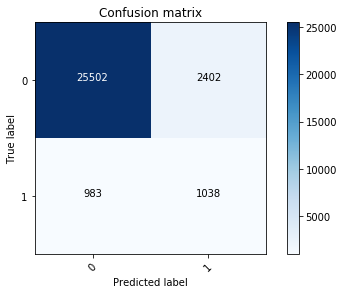

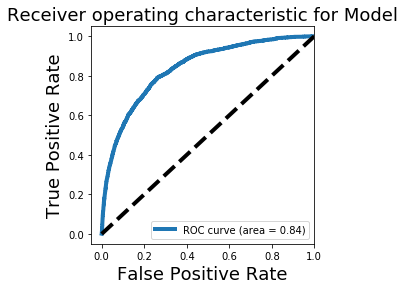

Auc: 0.8382853479548455


In [92]:
# score model
score_rfc_gs = model_rfc_gs.score(Xs_test, y_test)

print ('Accuracy Score: {}' .format(score_rfc_gs), '\n')

pred_rfc_gs = model_rfc_gs.predict(Xs_test)

cm_rfc_gs = confusion_matrix(y_test, pred_rfc_gs)

print (classification_print, '\n')

print ('Classification report: \n', classification_report(y_test, pred_rfc_gs), '\n')

print (cm_rfc_gs, '\n')

plot_confusion_matrix(cm_rfc_gs, classes)


# Plotting AUC Curve
model_performance(model_rfc_gs, Xs_test, y_test)

In [93]:
# checking for features

feat = []
for feature in zip(X_train.columns.values, model_rfc_gs.feature_importances_):
    feat.append(feature)
    
feat_df_rfc = pd.DataFrame(feat, columns=['Feature', 'Value'])
feat_df_rfc.sort_values('Value', ascending=False)

,Feature,Value
0,RevolvingUtilizationOfUnsecuredLines,0.297873
2,NumberOfTime30-59DaysPastDueNotWorse,0.142399
5,NumberOfTimes90DaysLate,0.123664
1,age,0.089000
3,DebtRatio,0.088802
9,MonthlyIncome_1,0.077807
7,NumberOfTime60-89DaysPastDueNotWorse,0.072244
4,NumberOfOpenCreditLinesAndLoans,0.059051
6,NumberRealEstateLoansOrLines,0.028008
8,NumberOfDependents,0.021154


#### RFC Upsampled GridSearch

In [96]:
rfc_up = RandomForestClassifier()

param = {'criterion':['gini'],
              'n_estimators': [30, 40, 50, 100, 150],
             'max_depth':[10, 15]}

   
#fit gridsearch with model, param_grid, cv_itr
grid_rfc_up = GridSearchCV(rfc_up, param, verbose=2, cv=10)

# fit model
grid_rfc_up.fit(Xs_train_up, y_train_up)

grid_rfc_up.best_params_
model_rfc_gs_up = grid_rfc_up.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   4.9s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   4.9s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   4.9s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   4.8s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   4.8s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   4.8s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   5.0s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   4.9s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .

[CV] .... criterion=gini, max_depth=15, n_estimators=30, total=   6.4s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   8.6s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   8.3s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   8.6s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   8.4s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   8.5s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   8.7s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 27.1min finished


Score: 0.8666666666666667 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.89      0.93     27904
          1       0.27      0.57      0.37      2021

avg / total       0.92      0.87      0.89     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[24782  3122]
 [  868  1153]]


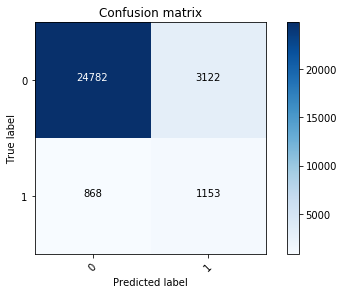

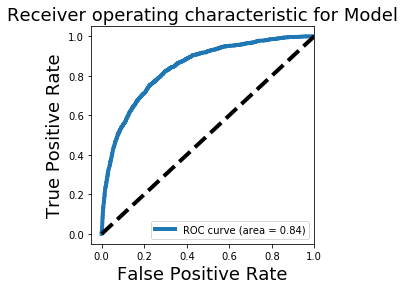

Auc: 0.8417436689700801


In [97]:

# score model
score_rfc_gs_up = model_rfc_gs_up.score(Xs_test_up, y_test)

print ('Score: {}' .format(score_rfc_gs_up), '\n')


pred_rfc_gs_up = model_rfc_gs_up.predict(Xs_test_up)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_rfc_gs_up), '\n')
print (cm_print, '\n')

cm_rfc_gs_up = confusion_matrix(y_test, pred_rfc_gs_up)

plot_confusion_matrix(cm_rfc_gs_up, classes)


# Plotting AUC Curve

model_performance(model_rfc_gs_up, Xs_test_up, y_test)

In [98]:
# checking for features

feat = []
for feature in zip(X_train.columns.values, model_rfc_gs_up.feature_importances_):
    feat.append(feature)
    
feat_df_rfc_up = pd.DataFrame(feat, columns=['Feature', 'Value'])
feat_df_rfc_up.sort_values('Value', ascending=False)

,Feature,Value
0,RevolvingUtilizationOfUnsecuredLines,0.326262
5,NumberOfTimes90DaysLate,0.139367
2,NumberOfTime30-59DaysPastDueNotWorse,0.137378
3,DebtRatio,0.080423
1,age,0.080283
9,MonthlyIncome_1,0.069314
7,NumberOfTime60-89DaysPastDueNotWorse,0.068152
4,NumberOfOpenCreditLinesAndLoans,0.053784
6,NumberRealEstateLoansOrLines,0.026137
8,NumberOfDependents,0.018898


#### RFC Downsampled GridSearch

In [99]:
rfc_ds = RandomForestClassifier()

param = {'criterion':['gini'],
              'n_estimators': [30, 40, 50, 100, 150],
             'max_depth':[10, 15]
        }

    
#fit gridsearch with model, param_grid, cv_itr
grid_rfc_ds = GridSearchCV(rfc_ds, param, verbose=2, cv=10)

# fit model
grid_rfc_ds.fit(Xs_train_ds, y_train_ds)

grid_rfc_ds.best_params_
model_rfc_gs_ds = grid_rfc_ds.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.3s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.3s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.2s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .... criterion=gini, max_depth=10, n_estimators=30, total=   0.3s
[CV] criterion=gini, max_depth=10, n_estimators=30 ...................
[CV] .

[CV] .... criterion=gini, max_depth=15, n_estimators=30, total=   0.4s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   0.5s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   0.5s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   0.5s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   0.6s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   0.5s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .... criterion=gini, max_depth=15, n_estimators=40, total=   0.5s
[CV] criterion=gini, max_depth=15, n_estimators=40 ...................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


Score: 0.7884043441938179 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.98      0.79      0.87     27904
          1       0.21      0.76      0.33      2021

avg / total       0.93      0.79      0.84     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[22060  5844]
 [  488  1533]]


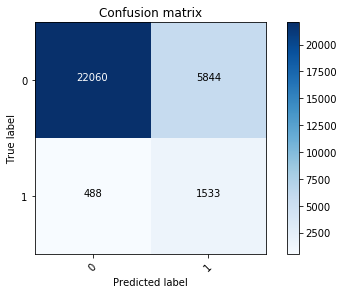

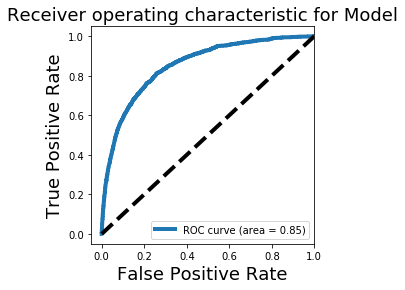

Auc: 0.8530190117442316


In [100]:
# score model
score_rfc_gs_ds = model_rfc_gs_ds.score(Xs_test_ds, y_test)

print ('Score: {}' .format(score_rfc_gs_ds), '\n')


pred_rfc_gs_ds = model_rfc_gs_ds.predict(Xs_test_ds)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_rfc_gs_ds), '\n')
print (cm_print, '\n')

cm_rfc_gs_ds = confusion_matrix(y_test, pred_rfc_gs_ds)

plot_confusion_matrix(cm_rfc_gs_ds, classes)


# Plotting AUC Curve

model_performance(model_rfc_gs_ds, Xs_test_ds, y_test)

In [101]:
# checking for features

feat = []
for feature in zip(X_train.columns.values, model_rfc_gs_ds.feature_importances_):
    feat.append(feature)
    
feat_df_rfc_ds = pd.DataFrame(feat, columns=['Feature', 'Value'])
feat_df_rfc_ds.sort_values('Value', ascending=False)

,Feature,Value
0,RevolvingUtilizationOfUnsecuredLines,0.292291
2,NumberOfTime30-59DaysPastDueNotWorse,0.122282
5,NumberOfTimes90DaysLate,0.117920
3,DebtRatio,0.100411
1,age,0.093829
9,MonthlyIncome_1,0.090052
4,NumberOfOpenCreditLinesAndLoans,0.066838
7,NumberOfTime60-89DaysPastDueNotWorse,0.059022
6,NumberRealEstateLoansOrLines,0.031002
8,NumberOfDependents,0.026354


### MLP Classifier

#### MLP Classifier Upsampled GridSearchCV

In [102]:
# defining model and params

mlpc = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu')
# mlpc.fit(Xs_train_up, y_train_up)


# param_grid_lr_gs = {'penalty':['l1', 'l2'],
#                     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]
#                    }

param = {'alpha':[0.0001, 0.001, 0.01, 1],
         'solver': ['lbfgs', 'adam']
        }
    
# fit gridsearch with model, param_grid, cv_tir
grid_mlpc_gs = GridSearchCV(mlpc, param, verbose=2, cv=5)

#fit model
grid_mlpc_gs.fit(Xs_train_up, y_train_up)

# get best param
grid_mlpc_gs.best_params_
model_mlpc_gs = grid_mlpc_gs.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total= 2.0min
[CV] alpha=0.0001, solver=lbfgs ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] ....................... alpha=0.0001, solver=lbfgs, total= 2.0min
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total= 2.0min
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total= 2.1min
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total= 2.0min
[CV] alpha=0.0001, solver=adam .......................................
[CV] ........................ alpha=0.0001, solver=adam, total= 2.7min
[CV] alpha=0.0001, solver=adam .......................................
[CV] ........................ alpha=0.0001, solver=adam, total= 2.2min
[CV] alpha=0.0001, solver=adam .......................................
[CV] ........................ alpha=0.0001, solver=adam, total= 2.4min
[CV] alpha=0.0001, solver=adam .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 77.0min finished


Score: 0.8273684210526315 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.84      0.90     27904
          1       0.22      0.61      0.32      2021

avg / total       0.92      0.83      0.86     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[23526  4378]
 [  788  1233]]


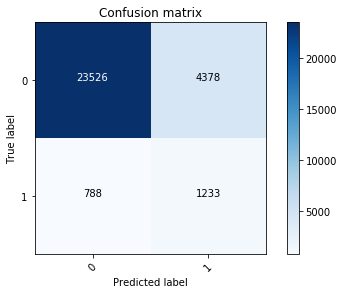

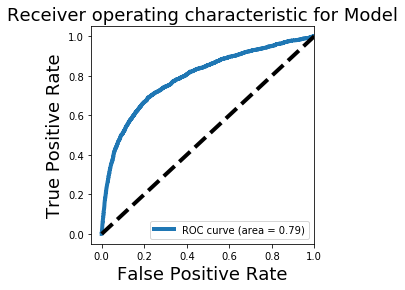

Auc: 0.7935240485935522


In [103]:
# score model
score_mlpc_gs_up = model_mlpc_gs.score(Xs_test_up, y_test)

print ('Score: {}' .format(score_mlpc_gs_up), '\n')


pred_mlpc_gs_up = model_mlpc_gs.predict(Xs_test_up)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_mlpc_gs_up), '\n')
print (cm_print, '\n')

cm_mlpc_gs_up = confusion_matrix(y_test, pred_mlpc_gs_up)

plot_confusion_matrix(cm_mlpc_gs_up, classes)


# Plotting AUC Curve

model_performance(model_mlpc_gs, Xs_test_up, y_test)

#### MLP Classifier Downsampled GridSearchCV

In [104]:
# defining model and params
mlpc_ds = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu')

param = {'alpha':[0.0001, 0.001, 0.01, 1],
         'solver': ['lbfgs', 'adam']
        }
    
    
#fit gridsearch with model, param_grid, cv_itr
grid_mlpc_ds = GridSearchCV(mlpc_ds, param, verbose=2, cv=5)


# fit model
grid_mlpc_ds.fit(Xs_train_ds, y_train_ds)


grid_mlpc_ds.best_params_
model_mlpc_gs_ds = grid_mlpc_ds.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total=   9.5s
[CV] alpha=0.0001, solver=lbfgs ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ....................... alpha=0.0001, solver=lbfgs, total=   9.3s
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total=   8.5s
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total=   9.9s
[CV] alpha=0.0001, solver=lbfgs ......................................
[CV] ....................... alpha=0.0001, solver=lbfgs, total=   8.5s
[CV] alpha=0.0001, solver=adam .......................................
[CV] ........................ alpha=0.0001, solver=adam, total=   1.7s
[CV] alpha=0.0001, solver=adam .......................................
[CV] ........................ alpha=0.0001, solver=adam, total=   2.5s
[CV] alpha=0.0001, solver=adam .......................................
[CV] ........................ alpha=0.0001, solver=adam, total=   3.0s
[CV] alpha=0.0001, solver=adam .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.0min finished


Score: 0.7933500417710944 

--------------------Classification Report-------------------- 

Classification report: 
              precision    recall  f1-score   support

          0       0.97      0.80      0.88     27904
          1       0.20      0.71      0.32      2021

avg / total       0.92      0.79      0.84     29925
 

--------------------Confusion Matrix-------------------- 

Confusion matrix, without normalization
[[22304  5600]
 [  584  1437]]


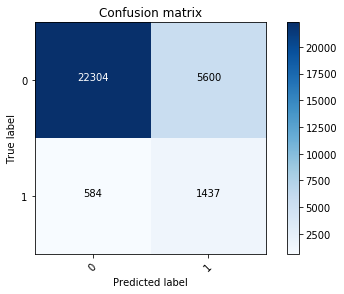

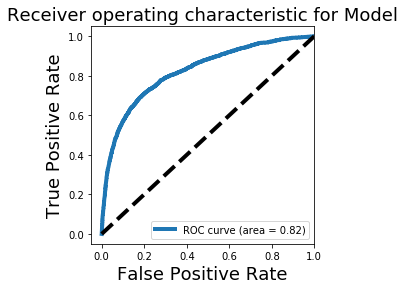

Auc: 0.8245249972053756


In [105]:
# score model
score_mlpc_gs_ds = model_mlpc_gs_ds.score(Xs_test_ds, y_test)

print ('Score: {}' .format(score_mlpc_gs_ds), '\n')


pred_mlpc_gs_ds = model_mlpc_gs_ds.predict(Xs_test_ds)

print (classification_print, '\n')
print ('Classification report: \n', classification_report(y_test, pred_mlpc_gs_ds), '\n')
print (cm_print, '\n')

cm_mlpc_gs_ds = confusion_matrix(y_test, pred_mlpc_gs_ds)

plot_confusion_matrix(cm_mlpc_gs_ds, classes)


# Plotting AUC Curve

model_performance(model_mlpc_gs_ds, Xs_test_ds, y_test)

## Conclusion

Based on the above findings, we can conclude that some of the models outperform the others. Given the computational speed and accuracy of a model, the optimal model to predict if a customer will be in financial distress in the next 2 years would be Random Forest Classifier (with downsampling) model. 